# Inverse trasform sampling

In [30]:
import timeit
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

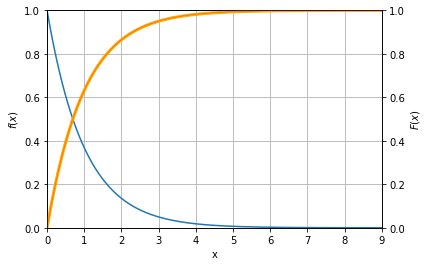

In [166]:
x_max = 9
x = np.linspace(0, x_max, 9000)

f = lambda x : np.exp(-x)
F = lambda x: 1 - np.exp(-x)
F_inv = lambda x : -np.log(1 - x)

delta = x[1] - x[0]
F_emp = delta * np.cumsum(f(x))
F_emp.shape

fig, ax1 = plt.subplots() 
plt.plot(x, f(x))
plt.ylabel('$f(x)$')
plt.xlabel('x')
plt.xlim([0, x_max])
plt.ylim([0, 1])
plt.grid()
ax2 = ax1.twinx()
ax2.plot(x, F(x), color='orange', lw=3)
ax2.set_ylabel('$F(x)$')
ax2.set_xlim([0, x_max])
ax2.set_ylim([0, 1])
ax2.plot(x, F_emp, color='red', lw=0.2)

In [85]:
def plot_hist(samples):
    plt.figure()
    hist = plt.hist(samples, bins=100, density=True, color='orange', edgecolor='white')  
    plt.plot(hist[1], f(hist[1]), color='red', lw=2)
    plt.xlim([0, x_max])
    plt.ylim([0, 1])
    plt.grid()

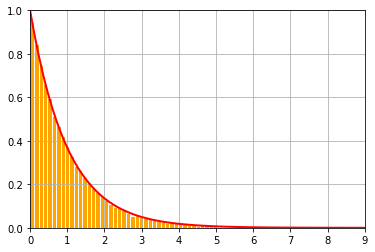

In [169]:
rnd = np.random.uniform(0, 1, 100000)
samples = F_inv(rnd)
plot_hist(samples)

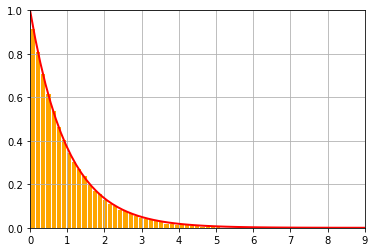

In [170]:
samples = []
for itt in range(100000):
    rnd = np.random.uniform()
    samples.append(F_inv(rnd))

plot_hist(samples)

In [77]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

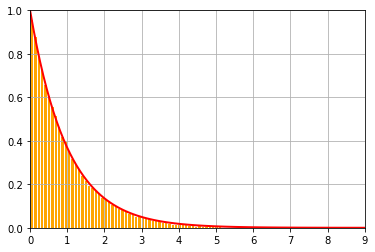

In [171]:
samples = []
for itt in range(100000):
    rnd = np.random.uniform()
    idx = find_nearest(F(x), rnd)
    samples.append(x[idx])

plot_hist(samples)

# Accept-reject sampling

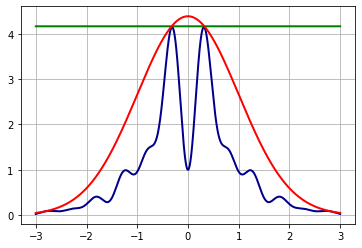

In [10]:
num_grids = 10000
x = np.linspace(-3, 3, 6 * num_grids)
f = lambda x : np.exp(-x ** 2 / 2) * (np.square(np.sin(6 * x)) + 3 * np.square(np.cos(x)) * np.square(np.sin(4 * x)) + 1)
g1 = np.vectorize(lambda x : 1/6)
g2 = lambda x: stats.norm(loc=0, scale=1).pdf(x)

C1 = 25
C2 = 11

plt.plot(x, f(x), color='darkblue', lw=2)
plt.plot(x, C1 * g1(x), color='green', lw=2)
plt.plot(x, C2 * g2(x), color='red', lw=2)
plt.grid()


In [11]:
delta = x[1] - x[0]
area = delta * np.sum(f(x))
print(area)

5.879613782199517


In [87]:
def plot_hist(samples, area):
    plt.figure()
    hist = plt.hist(samples, bins=100, density=True, color='orange', edgecolor='white')  
    plt.plot(hist[1], f(hist[1]) / area, color='red', lw=2)
    plt.grid()

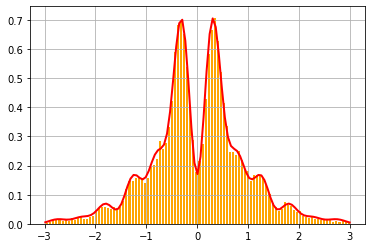

In [13]:
itts = 100000
samples = []

for itt in range(itts):
    x = np.random.uniform(-3, 3)
    u = np.random.uniform(0, C1 * g1(x))
    
    if u < f(x):
        samples.append(x)
    
plot_hist(samples, area)

In [14]:
def acc_rej_sampler(gaussian, C, itts=100_000):
    if gaussian:
        x = np.random.randn(itts)
        u = np.random.uniform(0, C * g2(x))
    else:
        x = np.random.uniform(-3, 3, itts)
        u = np.random.uniform(0, C * g1(x))

    samples = x[u < f(x)]
    return samples

In [15]:
samples_gauss = acc_rej_sampler(True, C1)
samples_unif = acc_rej_sampler(True, C2)

In [16]:
print('acceptance rate for uniform proposal function: {}%'.format(100 * len(samples_unif) / itts))
print('acceptance rate for normal proposal function: {}%'.format(100 * len(samples_gauss) / itts))

acceptance rate for uniform proposal function: 53.839%
acceptance rate for normal proposal function: 23.55%


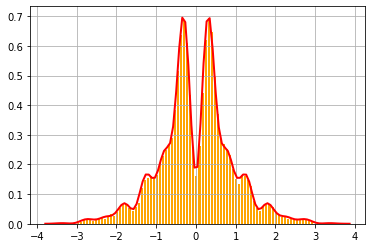

In [17]:
plot_hist(samples_unif, area)

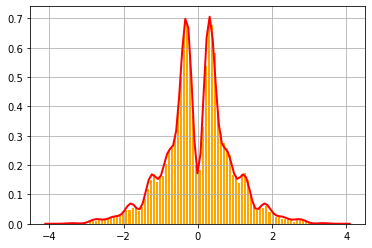

In [18]:
plot_hist(samples_gauss, area)

In [83]:
def plot_corr(samples):
    plt.figure()
    plt.scatter(samples[:-1], samples[1:], s=1)
    plt.xlabel('Previous Sample', fontsize=16)
    plt.ylabel('Current Sample', fontsize=16)
    corr = round(stats.pearsonr(samples[:-1], samples[1:])[0], 2)
    plt.title('Correlation: {}'.format(corr, fontsize=20))

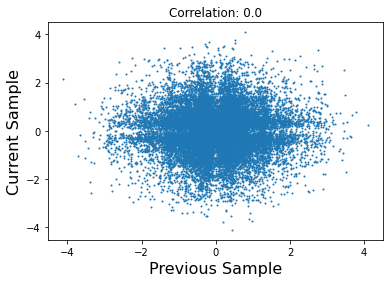

In [66]:
plot_corr(samples_gauss)

# MCMC sampling: Metropolis

In [76]:
def metroplois_sampler(gaussian=True, itts=1_000_000):
    samples = [0]
    num_accept = 0
    
    for itt in range(itts - 1):
        curr = samples[-1]
        if gaussian:
            x = np.random.normal(loc=curr, scale=1)
        else:
            x = np.random.uniform(-3, 3)
        ratio = f(x) / f(curr)
        
        #probability of accepting this candidate
        prob = min(1, ratio)
        
        if np.random.random() <= prob:
            samples.append(x)
            num_accept += 1
        else:
            samples.append(curr)
    
    return samples, num_accept

In [77]:
starttime = timeit.default_timer()       
samples_normal, num_accept_normal = metroplois_sampler()
print("The time difference is : {} sec".format(timeit.default_timer() - starttime))        

starttime = timeit.default_timer()       
samples_uniform, num_accept_uniform = metroplois_sampler(False)
print("The time difference is : {} sec".format(timeit.default_timer() - starttime))        

The time difference is : 19.475010811001994 sec
The time difference is : 19.06368514399219 sec


In [79]:
burn_in = int(itts / 100)
kept_samples_normal = samples_normal[burn_in:]
kept_samples_uniform = samples_uniform[burn_in:]

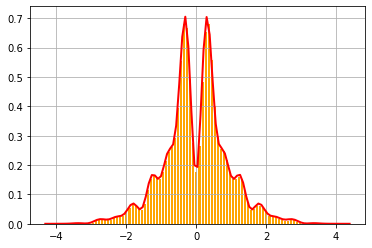

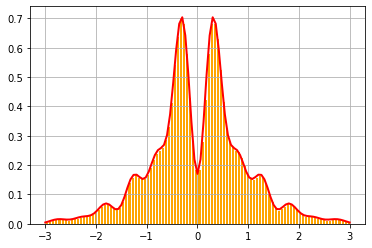

In [88]:
plot_hist(kept_samples_normal, area)
plot_hist(kept_samples_uniform, area)

In [89]:
print('acceptance rate for normal proposal function: {}%'.format(100 * num_accept_normal / len(kept_samples_normal)))
print('acceptance rate for uniform proposal function: {}%'.format(100 * num_accept_uniform / len(kept_samples_uniform)))

acceptance rate for normal proposal function: 59.11501501501502%
acceptance rate for uniform proposal function: 43.177877877877876%


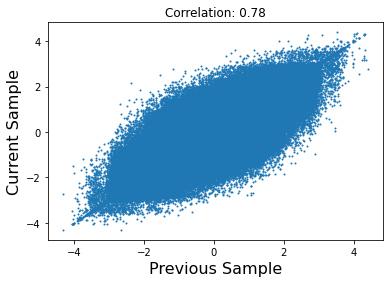

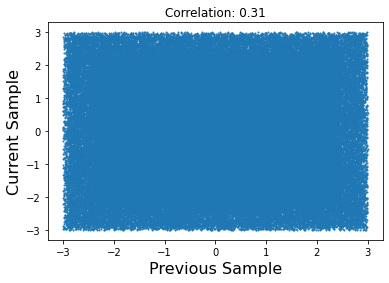

In [84]:
plot_corr(kept_samples_normal)
plot_corr(kept_samples_uniform)